In [1]:
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import *
from pyspark.sql.functions import stddev_pop, avg,stddev
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier
import pyspark.sql.functions as F
from pyspark.mllib.linalg import Matrices
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql import SparkSession

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

In [18]:
#Data = pd.read_csv("https://github.com/bigdata-i523/hid328/blob/master/project/data/german_credit.csv")
#Data = pd.read_csv("../data/german_credit.csv")

In [7]:
Data.head(10)

,Creditability,Account_Balance,Duration_of_Credit,Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,employment,Instalment_percent,Sex_MaritalStatus,...,Duration_address,asset,Age,Concurrent_Credits,Type_apartment,No_of_Credits,Occupation,dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2
5,1,1,10,4,0,2241,1,2,1,3,...,3,1,48,3,1,2,2,2,1,2
6,1,1,8,4,0,3398,1,4,1,3,...,4,1,39,3,2,2,2,1,1,2
7,1,1,6,4,0,1361,1,2,2,3,...,4,1,40,3,2,1,2,2,1,2
8,1,4,18,4,3,1098,1,1,4,2,...,4,3,65,3,2,2,1,1,1,1
9,1,2,24,2,3,3758,3,1,1,2,...,4,4,23,3,1,1,1,1,1,1


In [8]:
%matplotlib inline
sn.set(color_codes=True)

In [14]:

spark = SparkSession.builder.appName("analytics").master("local").getOrCreate()
csvDF = spark.read.format("csv").option("header","true").option("inferSchema", "true").load("../data/german_credit.csv")

In [15]:
csvPandas=csvDF.toPandas()

In [16]:
csvPandas.head(10)

,Creditability,Account_Balance,Duration_of_Credit,Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,employment,Instalment_percent,Sex_MaritalStatus,...,Duration_address,asset,Age,Concurrent_Credits,Type_apartment,No_of_Credits,Occupation,dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2
5,1,1,10,4,0,2241,1,2,1,3,...,3,1,48,3,1,2,2,2,1,2
6,1,1,8,4,0,3398,1,4,1,3,...,4,1,39,3,2,2,2,1,1,2
7,1,1,6,4,0,1361,1,2,2,3,...,4,1,40,3,2,1,2,2,1,2
8,1,4,18,4,3,1098,1,1,4,2,...,4,3,65,3,2,2,1,1,1,1
9,1,2,24,2,3,3758,3,1,1,2,...,4,4,23,3,1,1,1,1,1,1


Text(0,0.5,'Frequency')

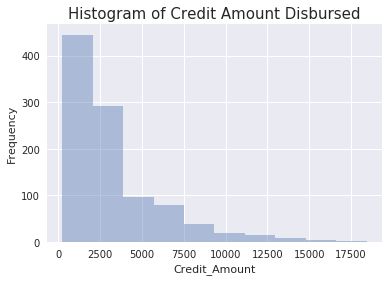

In [12]:
sn.distplot(csvPandas.Credit_Amount, kde = False,bins=10 )
plt.title( "Histogram of Credit Amount Disbursed", fontsize = 15)
plt.ylabel( "Frequency")


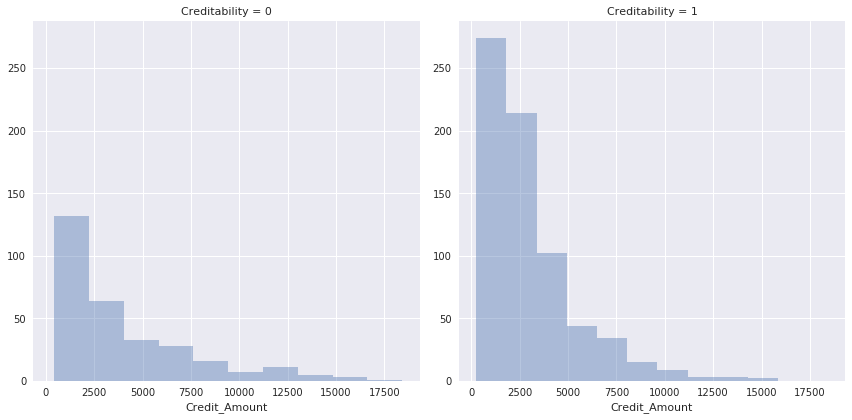

In [13]:
g = sn.FacetGrid(csvPandas, col="Creditability", size = 6)
g.map(sn.distplot, "Credit_Amount", kde = False, bins = 10 )

Text(0,0.5,'Frequency')

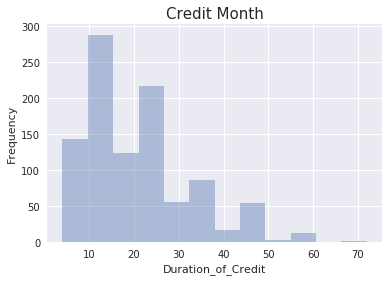

In [21]:
sn.distplot(csvPandas.Duration_of_Credit, kde = False,bins=12)
plt.title( "Credit Month", fontsize = 15)
plt.ylabel( "Frequency")

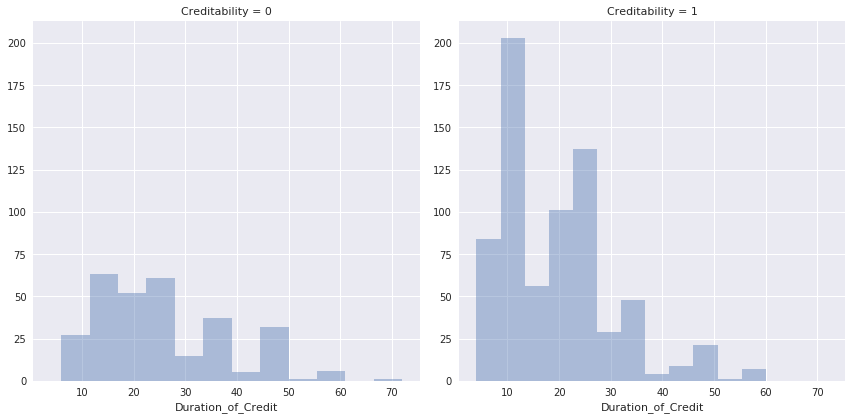

In [22]:
g = sn.FacetGrid(csvPandas, col="Creditability", size = 6)
g.map(sn.distplot, "Duration_of_Credit", kde = False, bins = 12)

Text(0,0.5,'Frequency')

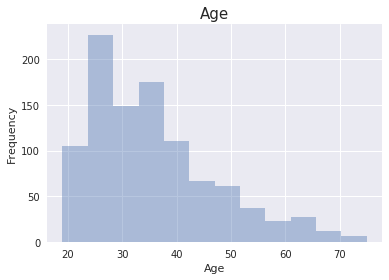

In [23]:
sn.distplot(csvPandas.Age, kde = False,bins=12)
plt.title( "Age", fontsize = 15)
plt.ylabel( "Frequency")

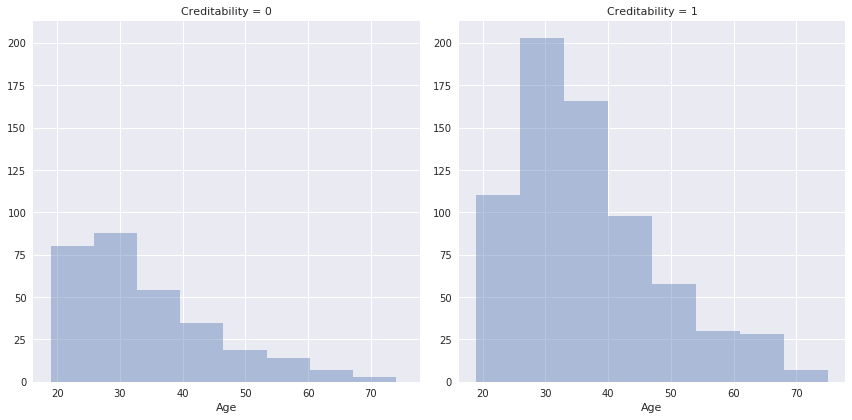

In [24]:
g = sn.FacetGrid(csvPandas, col="Creditability", size = 6)
g.map(sn.distplot, "Age", kde = False, bins = 8)

In [25]:
csvDF.select("Creditability").groupBy("Creditability").count().show()

+-------------+-----+
|Creditability|count|
+-------------+-----+
|            1|  700|
|            0|  300|
+-------------+-----+



In [28]:
rows=[]
rows.append((csvPandas['Credit_Amount'].min(),csvPandas.Credit_Amount.quantile(.25),csvPandas['Credit_Amount'].median(),csvPandas['Credit_Amount'].mean(),csvPandas.Credit_Amount.quantile(.75),csvPandas['Credit_Amount'].max()))
crAmountPerc = pd.DataFrame(rows,columns=["Min","1st Qu","Median","Mean","3rd Qu","Max"])
crAmountPerc.head()

,Min,1st Qu,Median,Mean,3rd Qu,Max
0,250,1365.5,2319.5,3271.248,3972.25,18424


In [31]:
dcrows=[]
dcrows.append((csvPandas['Duration_of_Credit'].min(),csvPandas.Duration_of_Credit.quantile(.25),csvPandas['Duration_of_Credit'].median(),csvPandas['Duration_of_Credit'].mean(),csvPandas.Duration_of_Credit.quantile(.75),csvPandas['Duration_of_Credit'].max()))
dcPerc = pd.DataFrame(dcrows,columns=["Min","1st Qu","Median","Mean","3rd Qu","Max"])
dcPerc.head()

,Min,1st Qu,Median,Mean,3rd Qu,Max
0,4,12.0,18.0,20.903,24.0,72


In [32]:
Agerows=[]
Agerows.append((csvPandas['Age'].min(),csvPandas.Age.quantile(.25),csvPandas['Age'].median(),csvPandas['Age'].mean(),csvPandas.Age.quantile(.75),csvPandas['Age'].max()))
agePerc = pd.DataFrame(Agerows,columns=["Min","1st Qu","Median","Mean","3rd Qu","Max"])
agePerc.head()

,Min,1st Qu,Median,Mean,3rd Qu,Max
0,19,27.0,33.0,35.542,42.0,75


In [20]:
data=csvDF.rdd.map(lambda x:(Vectors.dense(x[1:]), float(x[0]))).toDF(["features", "label"])

In [21]:
r = ChiSquareTest.test(data, "features", "label").head()

In [34]:
pdf=pd.DataFrame({'All':csvDF.columns[1:],'PValues':r.pValues.values,'Chi^2':r.statistics.values,'D.F':r.degreesOfFreedom})
pdf.head(21)

,All,Chi^2,D.F,PValues
0,Account_Balance,123.720944,3,0.000000e+00
1,Duration_of_Credit,78.886937,32,7.784572e-06
2,Previous_Credit,61.691397,4,1.279199e-12
3,Purpose,33.356447,9,1.157491e-04
4,Credit_Amount,931.746032,922,4.045155e-01
5,Value_Savings_Stocks,36.098928,4,2.761214e-07
6,employment,18.368274,4,1.045452e-03
7,Instalment_percent,5.476792,3,1.400333e-01
8,Sex_MaritalStatus,9.605214,3,2.223801e-02
9,Guarantors,6.645367,2,3.605595e-02


In [35]:
dataPanda = data.toPandas()
dataPanda.head(5)

,features,label
0,"[1.0, 18.0, 4.0, 2.0, 1049.0, 1.0, 2.0, 4.0, 2...",1.0
1,"[1.0, 9.0, 4.0, 0.0, 2799.0, 1.0, 3.0, 2.0, 3....",1.0
2,"[2.0, 12.0, 2.0, 9.0, 841.0, 2.0, 4.0, 2.0, 2....",1.0
3,"[1.0, 12.0, 4.0, 0.0, 2122.0, 1.0, 3.0, 3.0, 3...",1.0
4,"[1.0, 12.0, 4.0, 0.0, 2171.0, 1.0, 3.0, 4.0, 3...",1.0


In [36]:
(trainingData, testData) = data.randomSplit([0.7, 0.3])

In [37]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

In [38]:
dtModel=dt.fit(trainingData)

In [39]:
dtPredictions = dtModel.transform(testData)

In [40]:
dtPredictionsPanda = dtPredictions.toPandas()
dtPredictionsPanda.head(5)

,features,label,rawPrediction,probability,prediction
0,"[1.0, 6.0, 2.0, 0.0, 662.0, 1.0, 2.0, 3.0, 3.0...",1.0,"[17.0, 84.0]","[0.168316831683, 0.831683168317]",1.0
1,"[1.0, 6.0, 2.0, 0.0, 14896.0, 1.0, 5.0, 1.0, 3...",0.0,"[12.0, 34.0]","[0.260869565217, 0.739130434783]",1.0
2,"[1.0, 6.0, 4.0, 0.0, 860.0, 1.0, 5.0, 1.0, 2.0...",1.0,"[17.0, 3.0]","[0.85, 0.15]",0.0
3,"[1.0, 6.0, 4.0, 3.0, 338.0, 3.0, 5.0, 4.0, 3.0...",1.0,"[17.0, 3.0]","[0.85, 0.15]",0.0
4,"[1.0, 9.0, 2.0, 0.0, 654.0, 1.0, 3.0, 4.0, 3.0...",0.0,"[17.0, 3.0]","[0.85, 0.15]",0.0


In [41]:
def myConcat(*cols):
 return F.concat(*[F.coalesce(c, F.lit("*")) for c in cols])

In [44]:
dtMetricsData = dtPredictions.select("label","prediction")
dtMetricsWithNewColumn=dtMetricsData.withColumn("labelAndPrediction",myConcat('label','prediction'))
dtMetricsWithNewColumn.groupby('labelAndPrediction').count().toPandas().head()

,labelAndPrediction,count
0,0.01.0,65
1,1.00.0,24
2,1.01.0,188
3,0.00.0,30


In [43]:
dtEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
dtEvaluator.evaluate(dtPredictions)

0.7100977198697068

In [48]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [49]:
rfModel = rf.fit(trainingData)

In [50]:
print("number of Classes :"+str(rfModel.numClasses))

number of Classes :2


In [51]:
print("number of Features :"+str(rfModel.numFeatures))

number of Features :20


In [52]:
print("Total number of Nodes :"+str(rfModel.totalNumNodes))

Total number of Nodes :1002


In [53]:
predictions = rfModel.transform(testData)

In [54]:
predictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[1.0,6.0,2.0,0.0,...|  1.0|[5.15637491268248...|[0.25781874563412...|       1.0|
|[1.0,6.0,2.0,0.0,...|  0.0|[8.81428826427531...|[0.44071441321376...|       1.0|
|[1.0,6.0,4.0,0.0,...|  1.0|[5.96633089819497...|[0.29831654490974...|       1.0|
|[1.0,6.0,4.0,3.0,...|  1.0|[3.52715162730374...|[0.17635758136518...|       1.0|
|[1.0,9.0,2.0,0.0,...|  0.0|[9.45401679736380...|[0.47270083986819...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [55]:
metricsData = predictions.select("label","prediction")

In [56]:
metricsWithNewColumn=metricsData.withColumn("labelAndPrediction",myConcat('label','prediction'))


In [57]:
metricsWithNewColumn.groupby('labelAndPrediction').count().show()


+------------------+-----+
|labelAndPrediction|count|
+------------------+-----+
|            0.01.0|   67|
|            1.00.0|   13|
|            1.01.0|  199|
|            0.00.0|   28|
+------------------+-----+



In [58]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator.evaluate(predictions)

0.739413680781759

In [69]:
rfModel.featureImportances.values

array([ 0.27081728,  0.11274456,  0.09146886,  0.04328584,  0.09622944,
        0.06913785,  0.03938957,  0.03183868,  0.00883737,  0.02995981,
        0.0115001 ,  0.04954671,  0.07658997,  0.01374692,  0.01960307,
        0.0054999 ,  0.0107271 ,  0.0068088 ,  0.01010775,  0.00216044])

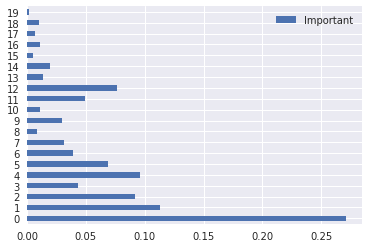

In [75]:
pdf=pd.DataFrame({'All':csvDF.columns[1:],'Important':rfModel.featureImportances.values})
pdf.plot.barh();
#pdf.head(21)
#pdf=pd.DataFrame(rfModel.featureImportances.values,index=20,columns=csvDF.columns[1:])